In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
# Load the dataset
data = pd.read_csv('/kaggle/input/superstore-sales-dataset/Superstore_Dataset.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   City           9994 non-null   object 
 9   State          9994 non-null   object 
 10  Region         9994 non-null   object 
 11  Product ID     9994 non-null   object 
 12  Category       9994 non-null   object 
 13  Sub-Category   9994 non-null   object 
 14  Product Name   9994 non-null   object 
 15  Sales          9994 non-null   float64
 16  Quantity       9994 non-null   int64  
 17  Discount       9994 non-null   float64
 18  Profit  

In [4]:
# Change datatypes
data = data.astype({'Row ID': object})

# Convert dates to datetime format
data['Order Date'] = pd.to_datetime(data['Order Date'])
data['Ship Date'] = pd.to_datetime(data['Ship Date'])

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   object        
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   City           9994 non-null   object        
 9   State          9994 non-null   object        
 10  Region         9994 non-null   object        
 11  Product ID     9994 non-null   object        
 12  Category       9994 non-null   object        
 13  Sub-Category   9994 non-null   object        
 14  Product Name   9994 non-null   object        
 15  Sales          9994 n

In [6]:
data.describe()

,Order Date,Ship Date,Sales,Quantity,Discount,Profit
count,9994,9994,9994.000000,9994.000000,9994.000000,9994.000000
mean,2019-04-30 17:41:20.448268800,2019-05-04 16:42:15.921553152,229.858014,3.789574,0.156203,28.656812
min,2017-01-03 00:00:00,2017-01-07 00:00:00,0.440000,1.000000,0.000000,-6599.980000
25%,2018-05-23 00:00:00,2018-05-27 00:00:00,17.280000,2.000000,0.000000,1.730000
50%,2019-06-26 00:00:00,2019-06-29 00:00:00,54.490000,3.000000,0.200000,8.665000
75%,2020-05-14 00:00:00,2020-05-18 00:00:00,209.940000,5.000000,0.200000,29.360000
max,2020-12-30 00:00:00,2021-01-05 00:00:00,22638.480000,14.000000,0.800000,8399.980000
std,NaN,NaN,623.245127,2.225110,0.206452,234.260186


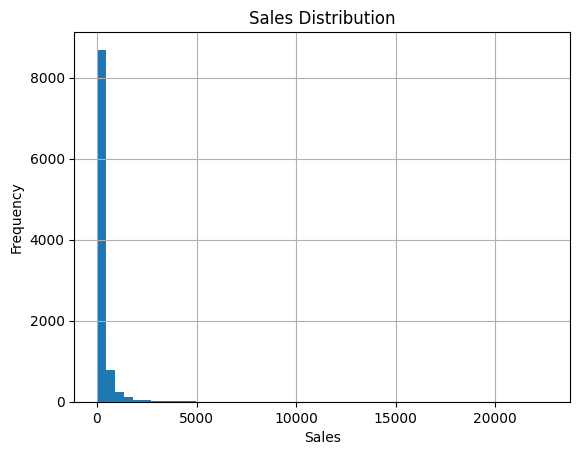

In [7]:
# Plot for distributions
data['Sales'].hist(bins=50)
plt.title('Sales Distribution')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

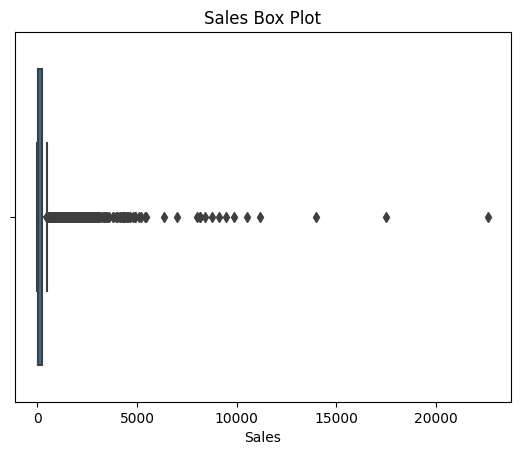

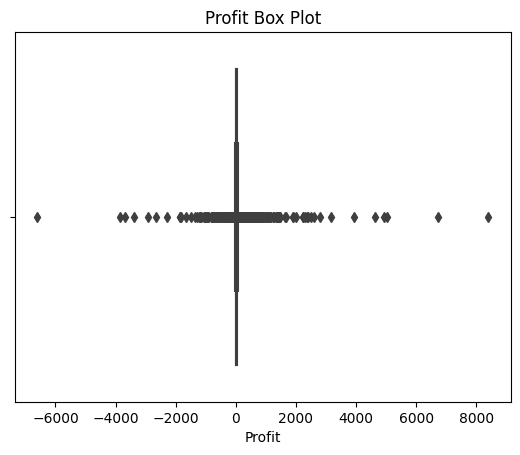

In [8]:
# Box plots for outliers
sns.boxplot(x=data['Sales'])
plt.title('Sales Box Plot')
plt.show()

sns.boxplot(x=data['Profit'])
plt.title('Profit Box Plot')
plt.show()

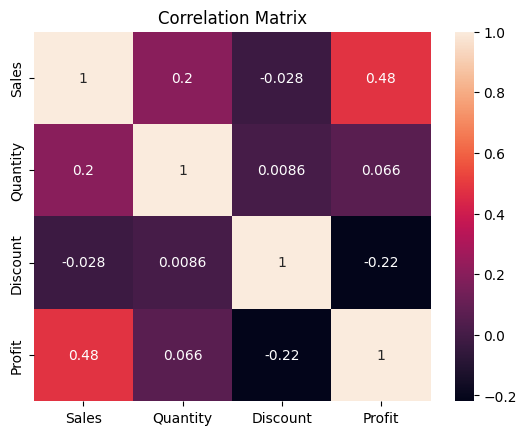

In [9]:
# Correlation matrix
corr_data = data.select_dtypes(include=['float64', 'int64']).columns
corr = data[corr_data].corr()

sns.heatmap(corr, annot=True)
plt.title('Correlation Matrix')
plt.show()

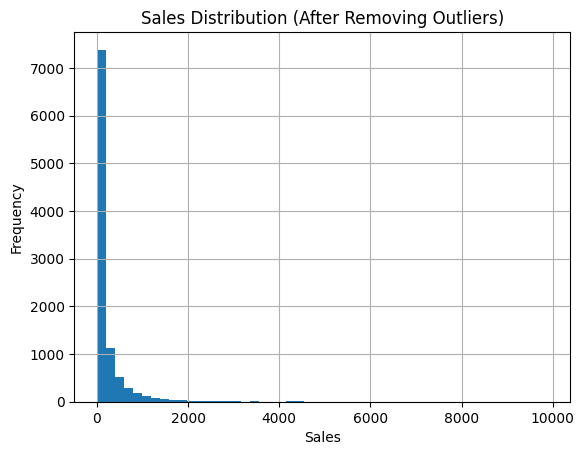

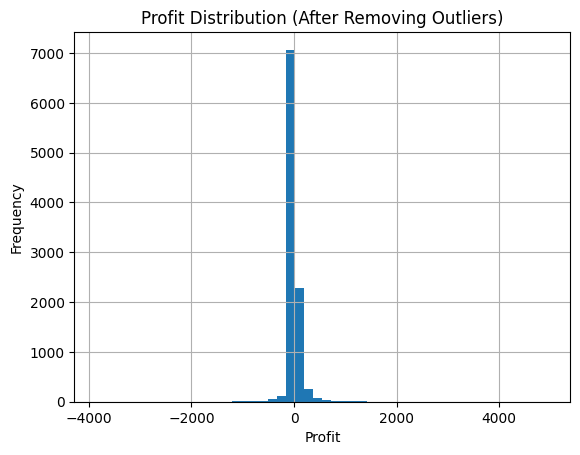

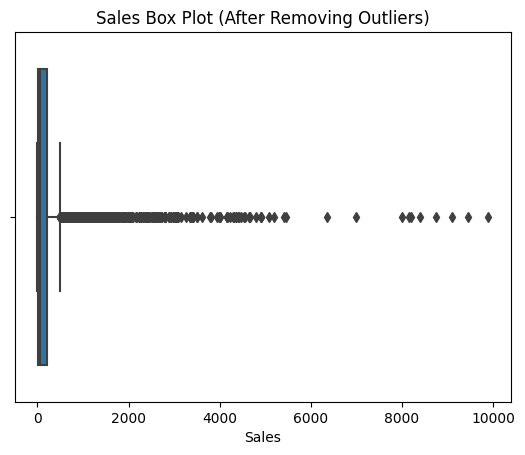

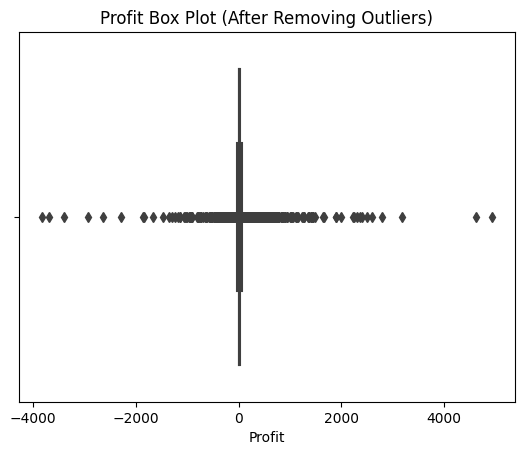

In [10]:
# Handling outliers: Remove extreme outliers beyond a certain threshold
def remove_outliers(df, column, minimum, maximum):
    return df[(df[column] >= minimum) & (df[column] <= maximum)]

# Remove outliers in Sales and Profit
data = remove_outliers(data, 'Sales', 0, 10000)
data = remove_outliers(data, 'Profit', -5000, 5000)

# Replot the distributions and box plots after removing outliers
data['Sales'].hist(bins=50)
plt.title('Sales Distribution (After Removing Outliers)')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

data['Profit'].hist(bins=50)
plt.title('Profit Distribution (After Removing Outliers)')
plt.xlabel('Profit')
plt.ylabel('Frequency')
plt.show()

sns.boxplot(x=data['Sales'])
plt.title('Sales Box Plot (After Removing Outliers)')
plt.show()

sns.boxplot(x=data['Profit'])
plt.title('Profit Box Plot (After Removing Outliers)')
plt.show()


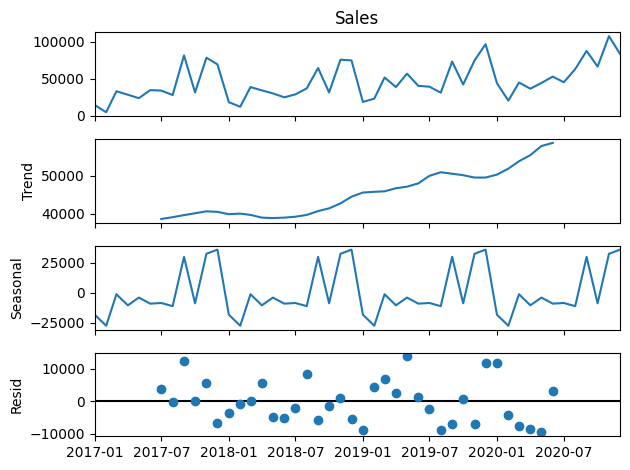

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


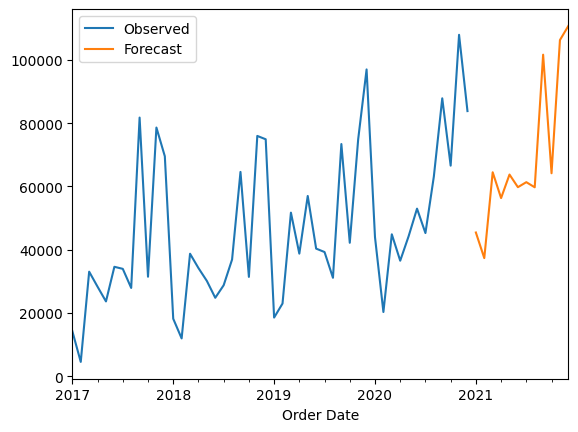

In [16]:
# Create a copy of the data with 'Order_Date' as the index for time series operations
ts_data = data.copy()
ts_data.set_index('Order Date', inplace=True)

# Aggregate monthly sales
monthly_sales = ts_data['Sales'].resample('MS').sum()

# Specify the period (e.g., 12 for monthly data)
period = 12

# Decompose time series
decomposition = seasonal_decompose(monthly_sales, model='additive', period=period)
decomposition.plot()
plt.show()

# Forecasting with Exponential Smoothing
model = ExponentialSmoothing(monthly_sales, trend='add', seasonal='add', seasonal_periods=period)
fit = model.fit()
forecast = fit.forecast(12)
monthly_sales.plot(label='Observed')
forecast.plot(label='Forecast')
plt.legend()
plt.show()

In [25]:
# Calculate error metrics
observed = monthly_sales[-12:]  # Last 12 months of observed data

# Explicitly set the index of predicted series to align with the observed series
predicted = forecast[:12]
predicted.index = observed.index

# Debug prints to check alignment and contents
print("Observed Series:")
print(observed)
print("Predicted Series:")
print(predicted)

# Check if the series are not empty
if len(observed) > 0 and len(predicted) > 0:
    # Calculate MAE and MSE
    mae = mean_absolute_error(observed, predicted)
    mse = mean_squared_error(observed, predicted)

    # Calculate MAPE, avoiding division by zero
    mask = observed != 0
    mape = (np.abs((observed[mask] - predicted[mask]) / observed[mask]).mean()) * 100

    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
else:
    print("The aligned observed and predicted series are empty. Please check the date ranges.")

Observed Series:
Order Date
2020-01-01     43971.37
2020-02-01     20301.12
2020-03-01     44872.39
2020-04-01     36521.52
2020-05-01     44261.08
2020-06-01     52981.72
2020-07-01     45264.43
2020-08-01     63120.85
2020-09-01     87866.66
2020-10-01     66576.99
2020-11-01    107947.84
2020-12-01     83829.31
Freq: MS, Name: Sales, dtype: float64
Predicted Series:
Order Date
2020-01-01     45441.549028
2020-02-01     37337.885963
2020-03-01     64487.045990
2020-04-01     56327.299000
2020-05-01     63763.883204
2020-06-01     59769.065688
2020-07-01     61354.367889
2020-08-01     59735.486299
2020-09-01    101664.996295
2020-10-01     64170.498419
2020-11-01    106286.793407
2020-12-01    110755.467917
Freq: MS, dtype: float64
Mean Absolute Error (MAE): 12373.738570803716
Mean Squared Error (MSE): 224179413.1186278
Mean Absolute Percentage Error (MAPE): 27.997274694823975%


In [ ]:
# Group by clusters and calculate mean values for each cluster
cluster_analysis = data.groupby('Cluster').mean()

# Display the characteristics of each cluster
print(cluster_analysis)

# Count the number of customers in each cluster
cluster_counts = data['Cluster'].value_counts()
print(cluster_counts)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


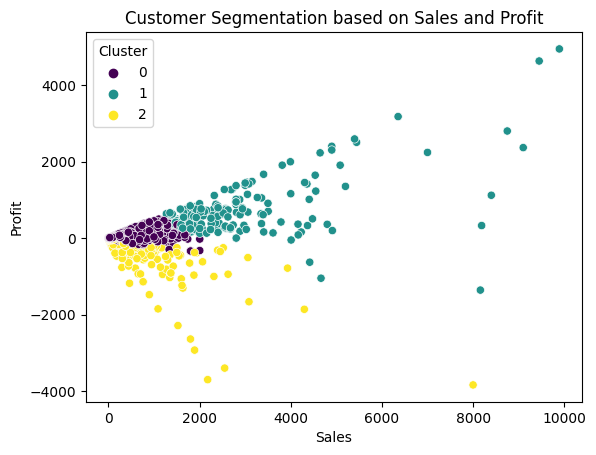

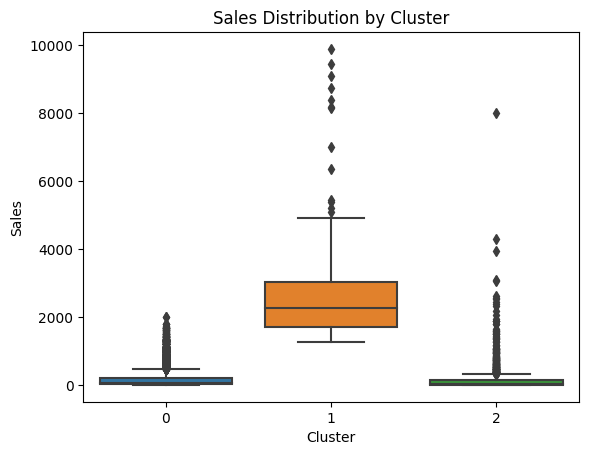

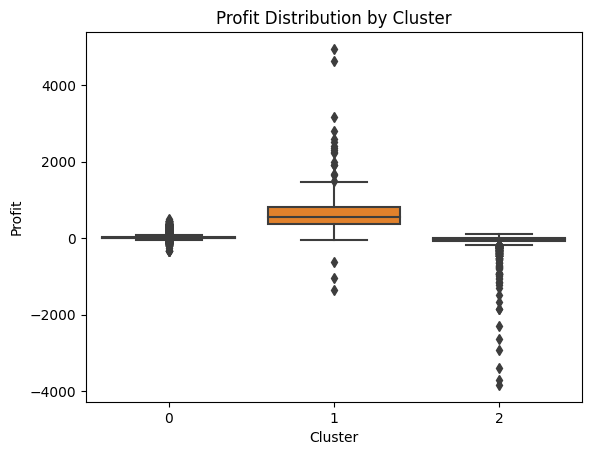

In [28]:
# Select features for clustering
features = data[['Sales', 'Profit', 'Discount', 'Quantity']]

# Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
data['Cluster'] = kmeans.fit_predict(scaled_features)

# Visualize the clusters
sns.scatterplot(x='Sales', y='Profit', hue='Cluster', data=data, palette='viridis')
plt.title('Customer Segmentation based on Sales and Profit')
plt.xlabel('Sales')
plt.ylabel('Profit')
plt.show()

# Box plot to show distribution of Sales and Profit in each cluster
sns.boxplot(x='Cluster', y='Sales', data=data)
plt.title('Sales Distribution by Cluster')
plt.show()

sns.boxplot(x='Cluster', y='Profit', data=data)
plt.title('Profit Distribution by Cluster')
plt.show()

In [34]:
# Select features for clustering
c_data = data[['Sales', 'Discount', 'Quantity', 'Profit', 'Cluster']]

# Group by clusters and calculate mean values for each cluster
cluster_analysis = c_data.groupby('Cluster').mean()

# Display the characteristics of each cluster
print(cluster_analysis)

# Count the number of customers in each cluster
cluster_counts = c_data['Cluster'].value_counts()
print(cluster_counts)

               Sales  Discount  Quantity      Profit
Cluster                                             
0         168.667196  0.094027  3.714121   28.347724
1        2753.654550  0.066750  6.450000  715.295000
2         182.086287  0.646058  3.892416 -103.750353
Cluster
0    8654
2    1134
1     200
Name: count, dtype: int64


In [40]:
# Add a new column 'Customer Category' based on the cluster values
data['Customer Category'] = data['Cluster'].map({
    1: 'High-valued',
    0: 'Moderate',
    2: 'Unprofitable'
})

In [41]:
data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Cluster,Customer Category
0,1,CA-2019-152156,2019-11-08,2019-11-11,Second Class,CG-12520,Claire Gute,Consumer,Henderson,Kentucky,...,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.00,41.91,0,Moderate
1,2,CA-2019-152156,2019-11-08,2019-11-11,Second Class,CG-12520,Claire Gute,Consumer,Henderson,Kentucky,...,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.00,219.58,0,Moderate
2,3,CA-2019-138688,2019-06-12,2019-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,Los Angeles,California,...,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.00,6.87,0,Moderate
3,4,US-2018-108966,2018-10-11,2018-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,Fort Lauderdale,Florida,...,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.58,5,0.45,-383.03,2,Unprofitable
4,5,US-2018-108966,2018-10-11,2018-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,Fort Lauderdale,Florida,...,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.37,2,0.20,2.52,0,Moderate


In [42]:
data.to_csv('superstore_sales_dataset.csv')